## Recurrent Neural Networks

Humans don’t start their thinking from scratch every second. As you read this, you understand each word based on your understanding of previous words. You don’t throw everything away and start thinking from scratch again. Your thoughts have persistence.

Traditional neural networks can’t do this, and it seems like a major shortcoming. For example, imagine you want to classify what kind of event is happening at every point in a movie. It’s unclear how a traditional neural network could use its reasoning about previous events in the film to inform later ones.

Recurrent neural networks address this issue. They are networks with loops in them, allowing information to persist.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-rolled.png" style="height: 175px;" />  

                                            Recurrent Neural Networks have loops. 


In the above diagram, a chunk of neural network, $ A $, looks at some input $x_t$ and outputs a value $h_t$. A loop allows information to be passed from one step of the network to the next.
These loops make recurrent neural networks seem kind of mysterious. However, if you think a bit more, it turns out that they aren’t all that different than a normal neural network. A recurrent neural network can be thought of as multiple copies of the same network, each passing a message to a successor. Consider what happens if we unroll the loop:

<img src="https://blog.exxactcorp.com/wp-content/uploads/2019/01/1_PMeuhAtbcNskcO6qBJETvA-300x96.png" style="height: 150px;" />  


This chain-like nature reveals that recurrent neural networks are intimately related to sequences and lists. They’re the natural architecture of neural network to use for such data.

### When to use

Recurrent Neural Networks, or RNNs, were designed to work with sequence prediction problems.
Sequence prediction problems come in many forms and are best described by the types of inputs and outputs supported.

Some examples of sequence prediction problems include:
1. One-to-Many: An observation as input mapped to a sequence with multiple steps as an output.
2. Many-to-One: A sequence of multiple steps as input mapped to class or quantity prediction.
3. Many-to-Many: A sequence of multiple steps as input mapped to a sequence with multiple steps as output.

The Many-to-Many problem is often referred to as sequence-to-sequence, or seq2seq for short.

Use RNNs for:

Text data  
Speech data  
Classification prediction problems  
Regression prediction problems  
Generative models  

Generally, if you are dealing with time series datasets, then RNN is the first goto method.

### Long Term Dependency

One of the appeals of RNNs is the idea that they might be able to connect previous information to the present task, such as using previous video frames might inform the understanding of the present frame. If RNNs could do this, they’d be extremely useful. But can they? It depends.

Sometimes, we only need to look at recent information to perform the present task. For example, consider a language model trying to predict the next word based on the previous ones. If we are trying to predict the last word in “the clouds are in the sky,” we don’t need any further context – it’s pretty obvious the next word is going to be sky. In such cases, where the gap between the relevant information and the place that it’s needed is small, RNNs can learn to use the past information.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-shorttermdepdencies.png" style="height: 175px;" />  

But there are also cases where we need more context. Consider trying to predict the last word in the text “I grew up in France… I speak fluent French.” Recent information suggests that the next word is probably the name of a language, but if we want to narrow down which language, we need the context of France, from further back. It’s entirely possible for the gap between the relevant information and the point where it is needed to become very large.

Unfortunately, as that gap grows, RNNs become unable to learn to connect the information.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-longtermdependencies.png" style="height: 175px;" />  

### RNN Implementation

The problem we are going to look at in this post is the International Airline Passengers prediction problem.

This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

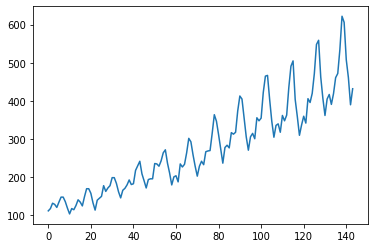

In [2]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataset)
plt.show()

In [10]:
import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
numpy.random.seed(7)

In [4]:
dataframe = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


We can phrase the problem as a regression problem.

That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?
We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

Now we can define a function to create a new dataset.  
The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [9]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design and fit our RNN for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 Simple RNN blocks or neurons, and an output layer that makes a single value prediction. The network is trained for 100 epochs and a batch size of 1 is used.

In [11]:
# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 4s - loss: 0.0378
Epoch 2/100
 - 0s - loss: 0.0155
Epoch 3/100
 - 0s - loss: 0.0127
Epoch 4/100
 - 0s - loss: 0.0111
Epoch 5/100
 - 0s - loss: 0.0098
Epoch 6/100
 - 0s - loss: 0.0085
Epoch 7/100
 - 0s - loss: 0.0072
Epoch 8/100
 - 0s - loss: 0.0060
Epoch 9/100
 - 0s - loss: 0.0049
Epoch 10/100
 - 0s - loss: 0.0041
Epoch 11/100
 - 0s - loss: 0.0034
Epoch 12/100
 - 0s - loss: 0.0028
Epoch 13/100
 - 0s - loss: 0.0025
Epoch 14/100
 - 0s - loss: 0.0023
Epoch 15/100
 - 0s - loss: 0.0022
Epoch 16/100
 - 0s - loss: 0.0021
Epoch 17/100
 - 0s - loss: 0.0020
Epoch 18/100
 - 0s - loss: 0.0020
Epoch 19/100
 - 0s - loss: 0.0020
Epoch 20/100
 - 0s - loss: 0.0020
Epoch 21/100
 - 0s - loss: 0.0020
Epoch 22/100
 - 0s - loss: 0.0020
Epoch 23/100
 - 0s - loss: 0.0021
Epoch 24/100
 - 0s - loss: 0.0020
Epoch 25/100
 - 0s - loss: 0.0020
Epoch 26/100
 - 0s - loss: 0.0020
Epoch 27/100
 - 0s - loss: 0.0020
Epoch 28/100
 - 0s - loss: 0.0019
Epoch 29/100
 - 0s - loss: 0.0019
Epoch 30/100
 - 0s - lo

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.
Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.42 RMSE
Test Score: 53.02 RMSE


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

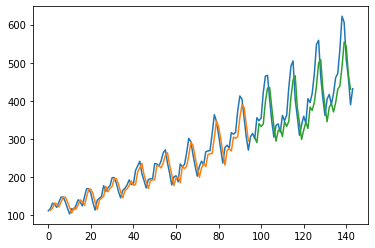

In [13]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()